# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import os
import joblib
import scipy.stats as stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

First we load the customers and the general population (azdias) datasets.

In [58]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
# Print the shapes of the loaded arrays
print('Shape of the customers data:', customers.shape) 
print('Shape of the general population data:', azdias.shape)

Shape of the customers data: (191652, 369)
Shape of the general population data: (891221, 366)


For data understanding, a reduced datasets is created with 'n_samples' randomly selected entries.

In [60]:
# number of samples to select
n_samples = 3000

# obtain random samples
z1 = azdias.shape[0]
x1 = range(1,z1)
y1 = random.sample(x1, n_samples)

# Obtain random samples
z2 = customers.shape[0]
x2 = range(1,z2)
y2 = random.sample(x2, n_samples)

# create reduced datasets for understanding the data
azdias_red, customers_red = azdias.iloc[y1,:].copy(), customers.iloc[y2,:].copy()

**Checkpoint**: Store the reduced datasets.

In [61]:
#store the reduced datasets to pickle
azdias_red.to_pickle("./azdias_red.pkl")
customers_red.to_pickle("./customers_red.pkl")

# remove old dataframes to save ram
del azdias, customers, azdias_red, customers_red, n_samples, x1, x2, y1, y2, z1, z2

**START HERE FOR PRAXIS**

Load the reduced datasets for data undersranding (**skip** this step for using the full datasets).

In [2]:
#load the reduced dataframes from the pickle files
azdias= pd.read_pickle("./azdias_red.pkl")
customers = pd.read_pickle("./customers_red.pkl")

### Data Understanding
The data is structured into customers data (**customers**) and data for the general population (**azdias**). The cells below are examplary for data understanding.

In [3]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
190844,131287,1,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,4.0,3.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,3
17184,134388,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,NaN,...,1.0,0.0,9.0,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
164414,71338,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,1.0,6.0,9.0,4.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
106362,17088,1,3.0,20.0,NaN,NaN,NaN,NaN,13.0,3.0,...,1.0,2.0,9.0,3.0,4,FOOD,MULTI_BUYER,0,1,4
180670,63539,2,1.0,9.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,6.0,9.0,1.0,1,COSMETIC,SINGLE_BUYER,0,1,4


In [4]:
# print info for customers data
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 190844 to 82247
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 8.5+ MB


In [5]:
# print info for general population data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 734188 to 72687
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 8.4+ MB


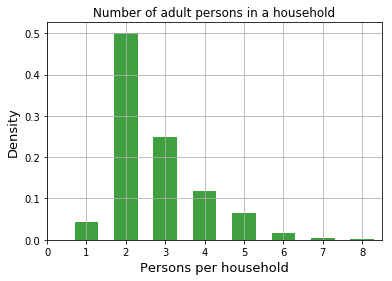

In [6]:
# plot number of persons known in houshold
fig = plt.figure()
x=azdias['ANZ_PERSONEN'].dropna().values
#ax.set(xlabel='ANZ_PERSONEN')
#ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')

r = np.array(range(0,31))+0.5
n, bins, patches = plt.hist(x+0.5,r,density=True, facecolor='g', alpha=0.75, rwidth=0.6)
plt.title('Number of adult persons in a household')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(0, 8.5)
plt.xlabel('Persons per household', fontsize=13)
plt.ylabel('Density', fontsize=13)
#plt.ylim(0, 0.03)
plt.grid(True)
plt.show()
fig.savefig('numb_persons.png', dpi=300)

In [7]:
# Show extra columns in customers
customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].head()

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
190844,MULTI_BUYER,0,COSMETIC_AND_FOOD
17184,MULTI_BUYER,0,COSMETIC_AND_FOOD
164414,MULTI_BUYER,0,COSMETIC_AND_FOOD
106362,MULTI_BUYER,0,FOOD
180670,SINGLE_BUYER,0,COSMETIC


In [8]:
# Find non-numeric columns
obj_cols=customers.select_dtypes(include= ['object']).columns
print(obj_cols)

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')


In [9]:
# count values in 'D19_LETZTER_KAUF_BRANCHE'
customers['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             483
D19_SONSTIGE              224
D19_BUCH_CD               181
D19_VERSICHERUNGEN        176
D19_VOLLSORTIMENT         127
D19_HAUS_DEKO             125
D19_SCHUHE                110
D19_BEKLEIDUNG_GEH        105
D19_DROGERIEARTIKEL        84
D19_ENERGIE                54
D19_BANKEN_DIREKT          53
D19_BEKLEIDUNG_REST        49
D19_LEBENSMITTEL           47
D19_VERSAND_REST           41
D19_TELKO_REST             36
D19_TECHNIK                35
D19_TELKO_MOBILE           33
D19_BANKEN_GROSS           30
D19_NAHRUNGSERGAENZUNG     29
D19_FREIZEIT               26
D19_RATGEBER               25
D19_KINDERARTIKEL          24
D19_WEIN_FEINKOST          24
D19_SAMMELARTIKEL          22
D19_BANKEN_REST            19
D19_HANDWERK               12
D19_GARTEN                 10
D19_BIO_OEKO               10
D19_REISEN                  9
D19_DIGIT_SERV              6
D19_TIERARTIKEL             6
D19_BANKEN_LOKAL            5
D19_LOTTO                   3
D19_BILDUN

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Data Preparation
For data preparation various **cleaning functions** are created. The cleaning steps are then performed with the function 'clean_df'. See the docstrings for a description of the function. 

In [10]:
# create cleaning functions
def custom_cleaning(df):
    '''
    This function performs custom cleaning steps.
    
    INPUT
    df - input data (DataFrame)
    
    OUTPUT
    df - cleaned output data (DataFrame)
    '''   
    # drop column with ID's
    df.drop(['LNR'], axis = 1, inplace=True)

    # replace values that represent 'unknown' with NaN and change dtypes
    for i, val in enumerate(df.columns):
        df[val].replace(to_replace=-1, value=float('nan'), inplace=True)
        df[val].replace(to_replace='-1', value=float('nan'), inplace=True)
        df[val].replace(to_replace='-1.0', value=float('nan'), inplace=True)
        if val[:2]=='LP':
            df[val]=df[val].astype('object', copy=False)
        if val[:4]=='SEMIO':
            df[val].replace(to_replace=9, value=float('nan'), inplace=True)
            
    # replace values that represent 'unknown' with NaN
    df['CAMEO_DEUG_2015'].replace(to_replace='X', value=float('nan'), inplace=True)
    df['CAMEO_INTL_2015'].replace(to_replace='XX', value=float('nan'), inplace=True)  
    df['CAMEO_DEU_2015'].replace(to_replace='XX', value=float('nan'), inplace=True)  
    df['ALTERSKATEGORIE_GROB'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['ALTERSKATEGORIE_GROB'].replace(to_replace=9, value=float('nan'), inplace=True)
    df['ANREDE_KZ'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['NATIONALITAET_KZ'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['RETOURTYP_BK_S'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['TITEL_KZ'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['ZABEOTYP'].replace(to_replace=9, value=float('nan'), inplace=True)
    df['CJT_GESAMTTYP'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['GEBAEUDETYP'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['HH_EINKOMMEN_SCORE'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['KKK'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['REGIOTYP'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['RELAT_AB'].replace(to_replace=9, value=float('nan'), inplace=True)
    df['WOHNDAUER_2008'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['W_KEIT_KIND_HH'].replace(to_replace=0, value=float('nan'), inplace=True)
    df['D19_KONSUMTYP'].replace(to_replace=9, value=float('nan'), inplace=True)
    
    # change dtypes
    df['CAMEO_DEUG_2015']=df['CAMEO_DEUG_2015'].astype('float64', copy=False)
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype('float64', copy=False)
    
    list_dtype = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'FINANZTYP', 'SHOPPER_TYP',
                 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ',
                 'ZABEOTYP', 'D19_KONSUMTYP', 'WOHNLAGE']
    
    for _, val in enumerate(list_dtype):
        df[val]=df[val].astype('object', copy=False)

    return df

# remove and store extra columns for customers
def remove_extra_columns(df):
    '''
    This function removes and stores extra columns in custormer df
    
    INPUT
    df - customers data (DataFrame)
    
    OUTPUT
    df_no_extra - customers data without extra columns (DataFrame)
    df_extra - extra columns from customers data (DataFrame)
    '''
    df_no_extra = df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)
    df_extra = df[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]
    
    return df_no_extra, df_extra

# remove rows with greater than frac of nan values
def remove_rows_nan(df, frac):
    '''
    This function removes rows with more than a fraction of nan values
    
    INPUT
    df - input data (DataFrame)
    frac - fraction of allowed nan values in row (float)
    
    OUTPUT
    df_clean - data with removed rows (DataFrame) 
    idx_rows - indices of the removed rows (Index object)
    '''
    idx_rows = df.loc[df.isnull().sum(axis=1)>frac*df.shape[1]].index
    df_clean=df.drop(idx_rows, axis=0)
    
    return df_clean, idx_rows
    
# remove columns with greater than frac of nan values
def remove_cols_nan(df, frac):
    '''
    This function removes columns with more than a fraction of nan values
    
    INPUT
    df - input data (DataFrame)
    frac - fraction of allowed nan values in column (float)
    
    OUTPUT
    df_clean - data with removed columns (DataFrame)
    idx_cols - labels of the removed columns (Index object)
    '''
    idx_cols = df.loc[:,df.isnull().sum(axis=0)>frac*df.shape[0]].columns
    df_clean=df.drop(idx_cols, axis=1)
    
    return df_clean, idx_cols

# remove duplicate data
def remove_duplicated(df):
    '''
    This function removes duplicated rows
    
    INPUT
    df - data (DataFrame)
    
    OUTOUT
    df_clean - data with removed rows (DataFrame)
    idx_duplicated - row indices of removed rows (Index object)
    '''
    idx_duplicated = df.loc[df.duplicated()].index
    df_clean = df.drop(idx_duplicated, axis=0)
    
    return df_clean, idx_duplicated

# parse str into int (e.g., 'CAMEO_DEUG_2015')
def find_digits(s):
    """
    This function extracts float and int numbers in strings.
    
    INPUT
    s - A string
    
    OUTPUT
    p or d- Floatingpoint number (float)
    s - The input string if no digits where detected (str)
    """

    p=re.match('\d+\.\d+$', str(s))
    d=re.match('\d+$', str(s))
    if p:
        return float(p[0])
    elif d:
        return float(d[0]) 
    elif s=='NaN':
        return float('nan')
    else:
        return s

# Extract year from date
def parse_date(df):
    '''
    This function outputs the year form a date in column 'EINGEFUEGT_AM'
    
    INPUT
    df - data with date (DataFrame)
    
    OUTPUT
    df - data with year (DataFrame)
    '''
    df['EINGEFUEGT_AM']=df['EINGEFUEGT_AM'].apply(lambda x: pd.to_datetime(x).year if (x is not'NaN') else float('nan'))
    
    return df

# create dummy variables for obj columns
def create_dummy(df):
    '''
    This function creates dummy variables for categorical attributes
    
    INPUT
    df - data (DataFrame)
    
    OUTPUT
    df - data with dummy variables (DataFrame)
    '''
    cat_cols_lst = df.select_dtypes(include= ['object']).columns
    df_cat =  df[cat_cols_lst]
    df_dummy=pd.get_dummies(df_cat, dummy_na = False)
    df.drop(cat_cols_lst, axis=1, inplace=True)
    df = pd.concat([df, df_dummy], axis=1, join='inner')
    
    return df

# Drop columns with no variability
def drop_cols_no_variability(df):
    '''
    This function removes columns with no variability
    
    INPUT
    df - input data (DataFrame)
    
    OUTPUT
    df - data with removed columns (DataFrame) 
    '''
    #Drop columns with no variablility
    for col in df.columns:
        if df[col].value_counts().shape[0]==1:
            df.drop(columns=[col], axis=1, inplace=True)
    
    return df

In [11]:
def clean_df(df, customer_in = True, frac = 0.9):
    '''
    Function that applies cleaning steps:
    1. Custom cleaning
    2. Remove and store extra columns for customers data
    3. Remove duplicate data
    4. Remove columns with 'frac' nan values
    5. Remove columns with no variability
    6. Parse strings with digits into floats
    7. Extract year from date
    8. Create dummy variables for obj columns
    
    INPUT
    df - data (DataFrame)
    customer_in - set 'True' for customer data, 'False' for azdias data (boolean)
    frac - fraction of nan values allowed in a column (float)
    
    OUTPUT
    df - cleaned data (DataFrame)
    df_extra - extra data in customer data (DataFrame)
    '''
    # Perform custom cleaning
    df = custom_cleaning(df)
    
    # Remove and store extra columns for customers data
    if customer_in==True:
        df, df_extra = remove_extra_columns(df)
    elif customer_in==False:
        df_extra=pd.DataFrame()
    else:
        raise ValueError('customer_in can be True or False only')
            
    # Remove duplicate data        
    df, idx_rows = remove_duplicated(df)
    
    # Remove columns with many of nan values
    df, idx_cols = remove_cols_nan(df, frac = frac)
  
    # Remove columns with no variability
    df = drop_cols_no_variability(df)
    
    # Parse strings with digits into floats
    # find type obj columns
    cols_obj = df.select_dtypes(include= ['object']).columns
    # parse columns
    for col in cols_obj:
        df[col].apply(find_digits)
    
    # Extract year from date
    df = parse_date(df)
    
    # Create dummy variables for obj columns
    df = create_dummy(df)
    
    # remove rows from df_extra
    if customer_in==True:
        df_extra=df_extra.drop(idx_rows, axis = 0)

    return df, df_extra

Execute the cleaning steps using 'clean_df'.

In [12]:
# clean data
df_customers, df_extra_customers = clean_df(customers, frac = 0.9)
df_azdias, df_extra_azdias = clean_df(azdias, customer_in = False, frac = 0.9)

# Obtain columns that are in azdias and in customers
# Print the shapes of the cleaned arrays
idx_cols_both=np.intersect1d(df_azdias.columns, df_customers.columns)
print('Shape of general population data before intersection:', df_azdias.shape)
print('Shape of customers data before intersection:', df_customers.shape)
df_azdias=df_azdias[idx_cols_both]
df_customers=df_customers[idx_cols_both]
print('Shape of general population data after intersection:', df_azdias.shape)
print('Shape of customers data after intersection:', df_customers.shape)

Shape of general population data before intersection: (2855, 600)
Shape of customers data before intersection: (2351, 600)
Shape of general population data after intersection: (2855, 600)
Shape of customers data after intersection: (2351, 600)


Next, we check whether the columns in the cleaned DataFrames were created as expected.

In [74]:
# show all the column labels in the cleaned DataFrame
for i, val in enumerate(df_azdias.columns):
    print(val)

AGER_TYP
AKT_DAT_KL
ALTERSKATEGORIE_FEIN
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_STATISTISCHE_HAUSHALTE
ANZ_TITEL
ARBEIT
BALLRAUM
CAMEO_DEUG_2015_1.0
CAMEO_DEUG_2015_2.0
CAMEO_DEUG_2015_3.0
CAMEO_DEUG_2015_4.0
CAMEO_DEUG_2015_5.0
CAMEO_DEUG_2015_6.0
CAMEO_DEUG_2015_7.0
CAMEO_DEUG_2015_8.0
CAMEO_DEUG_2015_9.0
CAMEO_DEU_2015_1A
CAMEO_DEU_2015_1B
CAMEO_DEU_2015_1C
CAMEO_DEU_2015_1D
CAMEO_DEU_2015_1E
CAMEO_DEU_2015_2A
CAMEO_DEU_2015_2B
CAMEO_DEU_2015_2C
CAMEO_DEU_2015_2D
CAMEO_DEU_2015_3A
CAMEO_DEU_2015_3B
CAMEO_DEU_2015_3C
CAMEO_DEU_2015_3D
CAMEO_DEU_2015_4A
CAMEO_DEU_2015_4B
CAMEO_DEU_2015_4C
CAMEO_DEU_2015_4D
CAMEO_DEU_2015_4E
CAMEO_DEU_2015_5A
CAMEO_DEU_2015_5B
CAMEO_DEU_2015_5C
CAMEO_DEU_2015_5D
CAMEO_DEU_2015_5E
CAMEO_DEU_2015_5F
CAMEO_DEU_2015_6A
CAMEO_DEU_2015_6B
CAMEO_DEU_2015_6C
CAMEO_DEU_2015_6D
CAMEO_DEU_2015_6E
CAMEO_DEU_2015_6F
CAMEO_DEU_2015_7A
CAMEO_DEU_2015_7B
CAMEO_DEU_2015_7C
CAMEO_DEU_2015_7D
CAMEO_DEU_2015_7E

**Checkpoint**: Store the cleaned DataFrames and column labels to disk so they can be loaded for unsupervised learning.

In [75]:
# Store the cleaned data as csv files
df_customers.to_csv('df_customers.csv', sep=';')
df_azdias.to_csv('df_azdias.csv', sep=';')

In [76]:
# Save extra data to pickle
joblib.dump(df_extra_customers, 'df_extra_customers.pkl', compress = 1)

['df_extra_customers.pkl']

In [77]:
# delete not used data
del azdias, customers, df_extra_azdias, obj_cols, idx_cols_both, df_customers, \
           df_azdias, df_extra_customers

### Unsupervised Learning

To find differences between the customers and the general population, we will perform a **Mann-Whitney U test** for each attribute of the data. The Mann-Whitney U test is a non-parametric test for statistical differences in the distribution of two datasets. We will use it to obtain a p-value that indicates the likelyhood for a statistical difference of the attributes. 

First we load the normalized DataFrames

In [172]:
# load normalized DataFrames
df_extra_customers = joblib.load('df_extra_customers.pkl')
customers=pd.read_csv('df_customers.csv', sep=';', index_col=0)
azdias=pd.read_csv('df_azdias.csv', sep=';', index_col=0)

In [173]:
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,W_KEIT_KIND_HH,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
190844,1.0,1.0,10.0,3.0,10.0,2,1.0,1.0,0.0,1.0,...,0,0,0,6.0,0,1,0,0,0,0
17184,2.0,1.0,10.0,4.0,10.0,2,NaN,NaN,0.0,3.0,...,0,0,0,NaN,0,0,1,0,0,0
164414,1.0,1.0,8.0,4.0,8.0,1,2.0,0.0,0.0,1.0,...,0,0,0,6.0,0,0,1,0,0,0
106362,1.0,3.0,13.0,4.0,20.0,1,3.0,0.0,0.0,3.0,...,0,0,0,2.0,0,0,0,1,0,0
180670,2.0,1.0,10.0,4.0,9.0,1,1.0,0.0,0.0,2.0,...,0,0,0,6.0,1,0,0,0,0,0


Next we perform the Mann-Whitney U test. Note that this is performed on the reduced datasets, as else many p-values are gettin 0 and can't be sorted anymore.

In [174]:
# Iterate through columns to find the p-value for each feature using a Mann-Whitney U test
p_values = []
features = []

for col in customers.columns:    
    x, y = customers[col].dropna(), azdias[col].dropna()
    p_val = stats.mannwhitneyu(x, y, alternative='two-sided')
    p_values.append(p_val[1])
    features.append(col)

In [175]:
# cast p_values and features into numpy array
p_arr = np.array([p_values, features]).T

# create a DataFrame and sort for p_values
df_p_values=pd.DataFrame(p_arr, columns=['p_value', 'features'])
df_p_values_cp=df_p_values.astype({'p_value': 'float64', 'features': 'object'}, copy=True)
df_p_values_cp.sort_values(by='p_value', axis=0, inplace=True, ascending=True)
df_p_values_cp.head(10)

,p_value,features
583,1.355877e-244,VK_ZG11
90,8.633324e-239,CJT_TYP_1
176,9.064690e-233,D19_SOZIALES
91,1.778472e-228,CJT_TYP_2
217,4.854569e-226,FINANZ_SPARER
219,1.142677e-223,FINANZ_VORSORGER
216,9.890682e-216,FINANZ_MINIMALIST
94,2.560460e-202,CJT_TYP_5
92,2.030703e-200,CJT_TYP_3
95,2.728184e-196,CJT_TYP_6


After the features were sorted by the p-values, we plot a top feature to visualize the difference in the distribution between customers and the general population. 

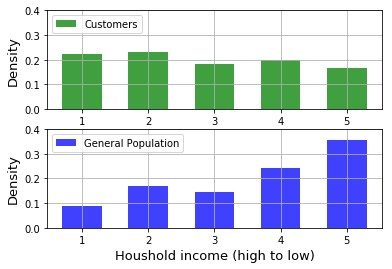

In [176]:
# plot comparison of distribution for customers and general population
x1=customers['HH_EINKOMMEN_SCORE'].dropna().values
x2=azdias['HH_EINKOMMEN_SCORE'].dropna().values
bins = np.array(range(0,6,1))+0.5
fig=plt.figure()
plt.subplot(2,1,1)
n, bins, patches = plt.hist(x1, bins = bins, density=True, facecolor='g', alpha=0.75, rwidth=0.6, label='Customers')
plt.xlabel('Houshold income (high to low)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.ylim((0,0.4))
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(2,1,2)
n, bins, patches = plt.hist(x2, bins = bins, density=True, facecolor='b', alpha=0.75, rwidth=0.6, label = 'General Population')
plt.xlabel('Houshold income (high to low)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.ylim((0,0.4))
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
fig.savefig('hh_income.png', dpi=300)

To obtain a value indicating the direction of statistical differences, we print the difference in the mean for the customers and general population groups.

In [177]:
# Print differenc in mean for the first ten features in the p-value list
for i, val in enumerate(df_p_values_cp['features']):
    if i < 20:
        m1 = customers[val].mean()
        m2 = azdias[val].mean()
        diff = m1-m2
        print('For %s the difference in the mean is %f.' % (val, diff))

For VK_ZG11 the difference in the mean is -2.711149.
For CJT_TYP_1 the difference in the mean is -1.270873.
For D19_SOZIALES the difference in the mean is 0.579996.
For CJT_TYP_2 the difference in the mean is -1.230367.
For FINANZ_SPARER the difference in the mean is -1.235662.
For FINANZ_VORSORGER the difference in the mean is 1.083675.
For FINANZ_MINIMALIST the difference in the mean is 1.172948.
For CJT_TYP_5 the difference in the mean is 1.106126.
For CJT_TYP_3 the difference in the mean is 1.109050.
For CJT_TYP_6 the difference in the mean is 1.034905.
For FINANZ_ANLEGER the difference in the mean is -1.201918.
For RT_KEIN_ANREIZ the difference in the mean is -1.189784.
For VK_DISTANZ the difference in the mean is -2.875813.
For AKT_DAT_KL the difference in the mean is -2.809055.
For CJT_TYP_4 the difference in the mean is 1.059692.
For KOMBIALTER the difference in the mean is 0.736799.
For ALTERSKATEGORIE_FEIN the difference in the mean is -3.325616.
For D19_KONSUMTYP_MAX the dif

For instance, we find for the feature 'ALTERSKATEGORIE_FEIN', that customers are younger in average than the general population.

**Checkpoint**: We have obtained two sorted lists of features expressing the statistical difference between the customers and the general population. We will save the lists to disk and use it in the supervised learning part below.

In [178]:
# store the p_values to disk
df_p_values_cp.to_pickle("./df_p_values_frac_09.pkl")

In [179]:
# delete variables
del df_p_values_cp, df_p_values, col, features, p_arr, p_val, p_values, \
        x, y, customers, df_extra_customers, azdias

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.


The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

First read the 'TRAIN' partition as a DataFrame.

In [191]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [192]:
# show the shape of the training DataFrame
mailout_train.shape

(42962, 367)

Load the sorted features list created in part 1.

In [193]:
# load dataframes from the pickle files
df_p_values = pd.read_pickle("./df_p_values_frac_09.pkl")
df_p_values['features'][:10]

583              VK_ZG11
90             CJT_TYP_1
176         D19_SOZIALES
91             CJT_TYP_2
217        FINANZ_SPARER
219     FINANZ_VORSORGER
216    FINANZ_MINIMALIST
94             CJT_TYP_5
92             CJT_TYP_3
95             CJT_TYP_6
Name: features, dtype: object

First we need to do some cleaning on the training data. Therefore we create the **TrainingDataCleaner class** that contains *fit* and *transform*  methods. See the docstring of the *transform* method for the steps involved.

In [194]:
# Create class for cleaning and normalization fit and transform
class TrainingDataCleaner(BaseEstimator, TransformerMixin):
    '''
    Parameters
    ----------
    df - data to be cleaned
    
    Attributes
    ----------
    features - list of features to keep (str)
    '''
    
    def __init__(self, features):
        self.features = features
        
    def custom_cleaning(self, df):
        '''
        This function performs custom cleaning steps.
    
        INPUT
        df - input data (DataFrame)
        
        OUTPUT
        df - cleaned output data (DataFrame)
        '''
        # drop column with ID's
        df.drop(['LNR'], axis = 1, inplace=True)

        # replace values that represent 'unknown' with NaN and change dtypes
        for i, val in enumerate(df.columns):
            df[val].replace(to_replace=-1, value=float('nan'), inplace=True)
            df[val].replace(to_replace='-1', value=float('nan'), inplace=True)
            df[val].replace(to_replace='-1.0', value=float('nan'), inplace=True)
            if val[:2]=='LP':
                df[val]=df[val].astype('object', copy=False)
            if val[:4]=='SEMIO':
                df[val].replace(to_replace=9, value=float('nan'), inplace=True)
            
        # replace values that represent 'unknown' with NaN
        df['CAMEO_DEUG_2015'].replace(to_replace='X', value=float('nan'), inplace=True)
        df['CAMEO_INTL_2015'].replace(to_replace='XX', value=float('nan'), inplace=True)  
        df['CAMEO_DEU_2015'].replace(to_replace='XX', value=float('nan'), inplace=True)  
        df['ALTERSKATEGORIE_GROB'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['ALTERSKATEGORIE_GROB'].replace(to_replace=9, value=float('nan'), inplace=True)
        df['ANREDE_KZ'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['NATIONALITAET_KZ'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['RETOURTYP_BK_S'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['TITEL_KZ'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['ZABEOTYP'].replace(to_replace=9, value=float('nan'), inplace=True)
        df['CJT_GESAMTTYP'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['GEBAEUDETYP'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['HH_EINKOMMEN_SCORE'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['KKK'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['REGIOTYP'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['RELAT_AB'].replace(to_replace=9, value=float('nan'), inplace=True)
        df['WOHNDAUER_2008'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['W_KEIT_KIND_HH'].replace(to_replace=0, value=float('nan'), inplace=True)
        df['D19_KONSUMTYP'].replace(to_replace=9, value=float('nan'), inplace=True)
    
        # change dtypes
        df['CAMEO_DEUG_2015']=df['CAMEO_DEUG_2015'].astype('float64', copy=False)
        df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype('float64', copy=False)
    
        list_dtype = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'FINANZTYP', 'SHOPPER_TYP',
                     'GFK_URLAUBERTYP', 'HEALTH_TYP', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ',
                     'ZABEOTYP', 'D19_KONSUMTYP', 'WOHNLAGE']
    
        for _, val in enumerate(list_dtype):
            df[val]=df[val].astype('object', copy=False)

        return df
       
    def find_digits(self, s):
        """
        This function extracts float and int numbers in strings.
    
        INPUT
        s - A string
    
        OUTPUT
        p or d - Floatingpoint number (float)
        s - The input string if no digits where detected (str)
        """
        p=re.match('\d+\.\d+$', str(s))
        d=re.match('\d+$', str(s))
        if p:
            return float(p[0])
        elif d:
            return float(d[0]) 
        elif s=='NaN':
            return float('nan')
        else:
            return s
    
    def parse_date(self, df):
        '''
        This function outputs the year form a date in column 'EINGEFUEGT_AM'
    
        INPUT
        df - data with date (DataFrame)
    
        OUTPUT
        df - data with year (DataFrame)
        '''
        df['EINGEFUEGT_AM']=df['EINGEFUEGT_AM'].apply(lambda x: pd.to_datetime(x).year if (x is not'NaN') else float('nan'))
        
        return df
    
    def create_dummy(self, df):
        '''
        This function creates dummy variables for categorical attributes
    
        INPUT
        df - data (DataFrame)
    
        OUTPUT
        df - data with dummy variables (DataFrame)
        '''
    
        cat_cols_lst = df.select_dtypes(include= ['object']).columns
        df_cat =  df[cat_cols_lst]
        df_dummy=pd.get_dummies(df_cat, dummy_na = False)
        df.drop(cat_cols_lst, axis=1, inplace=True)
        df = pd.concat([df, df_dummy], axis=1, join='inner')
        
        return df
        
    def reduce_df_to_features(self, df):
        '''
        This function reduces the data to the features stored in the features variable.
        
        INPUT
        df - data (DataFrame)
    
        OUTPUT
        df - data reduced to features (DataFrame)
        '''
        array_features = np.intersect1d(self.features,df.columns)
        df = df.loc[:,array_features]  
        return df
    
    def create_nan_counts_col(self, df):
        '''
        This function creates a DataFrame column counting the number of missing values in each row.
        
        INPUT
        df - data (DataFrame)
    
        OUTPUT
        df - data reduced to features (DataFrame)
        '''
        df['nan_counts'] = df.isnull().sum(axis=1).tolist()
        return df
        
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        '''
        The transform method applies the following data cleaning steps:
        
        1. Perform custom cleaning
        3. Parse strings with digits into float
        4. Extract year from date
        5. Create dummy variables
        6. Reduce DataFrame to input features
        7. Create column that counts Nan values in a row
        
        INPUT
        X - data (DataFrame)
        
        OUTPUT
        df_trans - transformed data (DataFrame)
        '''
        
        # Make a copy of the input DataFrame
        df_trans = X.copy(deep=True)
        
        # Perform custom cleaning
        df_trans = self.custom_cleaning(df_trans)
        
        # Parse strings with digits into floats
        # find type obj columns
        cols_obj = df_trans.select_dtypes(include= ['object']).columns
        
        # parse columns
        for col in cols_obj:
            df_trans[col].apply(self.find_digits)
    
        # Extract year from date
        df_trans = self.parse_date(df_trans)
        
        # Create dummy variables for obj columns
        df_trans = self.create_dummy(df_trans)
        
        #reduce datafream to input features
        df_trans = self.reduce_df_to_features(df_trans)
        
        # create columns that counts nan values in a row
        df_trans = self.create_nan_counts_col(df_trans)
        
        return df_trans

Next, a **Scaler class** is created that contains *fit* and *transform*  methods. It allows to perform min-max and standard scaling in a pipline.

In [195]:
# Scaler class
class Scaler(BaseEstimator, TransformerMixin):
    '''
    Normalizing transform with min-max or standard normalization
    
    Attributes:
    -----------
    mode : 'min-max' or 'standard' (str)
    params : for mode = 'min_max': list of (x_min, x_max) tuples for each column in data (float)
             for mode = 'standard': list of (mean, std) tuples for each column in data (float)
    '''
    def __init__(self, mode):
        self.mode = mode
        
    def extract_column(self, X):
        '''
        Geberator that yields the columns of a DataFrame object
        
        INPUT
        X - data (DataFrame)
        
        OUTPUT
        i - column index (int)
        col_array - single column of the data (numpy array)
        '''
        for i, value in enumerate(X.columns):
            col_array = np.array(X[value]).astype('float32')
            
            yield i, col_array
           
    def x_min_max(self, data):
        '''
        INPUT
        data - input data (Series)
        
        OUTPUT
        minimum - maximum value of the data (float)
        maximum - minimum value of the data (float)
        '''
        minimum = np.nanmin(data, axis = 0)
        maximum = np.nanmax(data, axis = 0)
        
        return minimum, maximum
    
    def x_std(self, data):
        '''
        INPUT
        data - input data (Series)
        
        OUTPUT
        mean - mean of the data (float)
        std - standard deviation of the data (float)
        '''
        mean = np.nanmean(data, axis = 0)
        std = np.nanstd(data, axis = 0)

        return mean, std
    
    def fit(self, X, y=None):
        '''
        Fit function
        
        INPUT:
        X - data (DataFrame)
        '''
        self.params = []
        
        if self.mode == 'min_max':
            for _, X_col in self.extract_column(X):
                self.params.append(self.x_min_max(X_col))
                
        if self.mode == 'standard':
            for _, X_col in self.extract_column(X):
                self.params.append(self.x_std(X_col))
            
        return self
    
    def transform(self, X):
        '''
        Transfrom function
        
        INPUT
        X - data (DataFrame)
        
        OUTPUT
        X_trans - normalized data (DataFrame)
        '''
        normalized = np.zeros((X.shape[0],1), dtype='float32')
        
        for i, X_col in self.extract_column(X):
            if self.mode == 'min_max':
                x_max = self.params[i][1]
                x_min = self.params[i][0]

                col_norm = (X_col-x_min)/(x_max-x_min)

                normalized = np.append(normalized, np.expand_dims(col_norm, axis=1), axis=1)
                
            elif self.mode == 'standard':
                x_std = self.params[i][1]
                x_mean = self.params[i][0]
            
                col_norm = (X_col-x_mean)/(x_std)
                normalized = np.append(normalized, np.expand_dims(col_norm, axis=1), axis=1)
                
  
        X_trans = pd.DataFrame(data=normalized[:,1:], columns=X.columns) 
        
        return X_trans
    

Next, a function is created to load the training data and return explanatory and response variables.

In [196]:
def load_data():
    '''
    This function loads the TRAIN data.
    
    INPUT
    None
    
    OUTPUT
    X - explanatory variables (DataFrame)
    y - response variable (DataFrame)
    '''
    mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)
    y = mailout_train['RESPONSE']
    X = mailout_train.drop(['RESPONSE'], axis=1)
    
    return X, y


Below the models are created and trained. We use a transform pipeline to scale the data and impute missing values, followed by different estimators. The best model is found using a grid search for the parameters of the model. We optimize the data by including different numbers of features in the data, as obtained from the unsupervised learning part. For the scoring we use ROC-AUC that is good for inbalanced datasets (other metrics such as accuracy work poorly on inbalanced datasets).

We start with training a **Logistic Regression** classifier.

Best AUC: 0.693449511999
AUC for test set: 0.69732494859
Number of features: 20
Best parameters:
{'clf__C': 1, 'imputer__strategy': 'median', 'scaler__mode': 'min_max'}


['num_features_logistic.pkl']

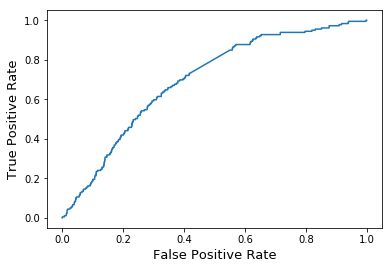

In [198]:
# build model for Logistic Regression
def build_model():
    '''
    This function builds the ML model using the following steps:
    1. Create pipline object using a list of (key, value) pairs
    2. Create dictinary of parameters to be optimized
    3. Create GridSearchCV object
    
    INPUT
    None
    
    OUTPUT
    cv - GridSearchCV object
    '''
    pipeline = Pipeline([
        ('scaler', Scaler(mode=None)),
        ('imputer', Imputer()),
        ('clf', LogisticRegression())
    ])

    parameters = {
        'imputer__strategy': ['mean','median'],
        'scaler__mode': ['min_max','standard'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    },
    
    cv = GridSearchCV(pipeline, param_grid = parameters, cv=3, scoring='roc_auc', refit=True)
    
    return cv

# main function
def main():
    '''
    This function finds the best model using the folowing steps:
    1. Load explanatory and response variables
    2. Perform a loop for an increasing number of features
    3. Clean the explanatory variables
    3. Split the data in train and test datasets
    4. Train model and predict on test dataset
    5. Store the best estimator, parameters, number of features and AUC score
    
    INPUT
    None
    
    OUTPUT
    fpr - false positive rates for the test data for the best model (ndarray)
    tpr - true positive rates for the test data for the best model (ndarray)
    threshold - thresholds on the decision function used to compute fpr and tpr (ndarray)
    y_scores - class probabilities of the test samples for the best model (ndarray)
    best_parameters - parameter setting for the best estimator (dict)
    best_estimator - estimator which gave highest score (object)
    results - number of features for best scores (dict)
    best_auc - mean cross-validated auc-score for the best model (float)
    auc_test_select - auc-score for the best model on the test data (float)
    '''
    # load explanatory and response variables
    X, y = load_data()
    best_auc = 0
    # make loop over features
    for f in range(2,30,2):
        features = df_p_values['features'][:f]
        
        # clean explanatory variables
        cleaner_obj_X = TrainingDataCleaner(features)
        X_1 = cleaner_obj_X.fit_transform(X)
        
        # split the data in train and test datasets
        X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.33, random_state=42)
        
        # train model and predict on test data
        model = build_model()
        model.fit(X_train, y_train)
        auc = model.best_score_
        y_probas = model.predict_proba(X_test)
        y_scores = y_probas[:,1]
        auc_test = roc_auc_score(y_test, y_scores)
        
        # store best estimator, parameters, number of features and auc scores
        if auc > best_auc:
            fpr, tpr, threshold = roc_curve(y_test, y_scores)
            best_parameters = model.best_params_
            best_estimator = model.best_estimator_
            results={'num_features': len(features)}
            auc_test_select = auc_test
            best_auc = auc
            
    return fpr, tpr, threshold, y_scores, best_parameters, best_estimator, results, best_auc, auc_test_select
    
fpr, tpr, threshold, y_scores, best_parameters, best_estimator, results, best_auc, auc_test_select = main()

# plot roc curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
ax.yaxis.label.set_size(13)
ax.xaxis.label.set_size(13)
fig.savefig('roc_curve_LR.png', dpi=300)

print('Best AUC:', best_auc)
print('AUC for test set:', auc_test_select)
print('Number of features:', results['num_features'])
print('Best parameters:')
print(best_parameters)

# store best estimator and number of features
joblib.dump(best_estimator, 'best_estimator_logistic.pkl', compress = 1)
joblib.dump(results['num_features'], 'num_features_logistic.pkl', compress = 1)

Next we train a **Random Forest** classifier.

Best AUC: 0.766185713533
AUC for test set: 0.750616265088
Number of features: 10
Best parameters:
{'clf__min_weight_fraction_leaf': 0.01, 'clf__n_estimators': 100, 'imputer__strategy': 'mean', 'scaler__mode': 'standard'}


['num_features_forest.pkl']

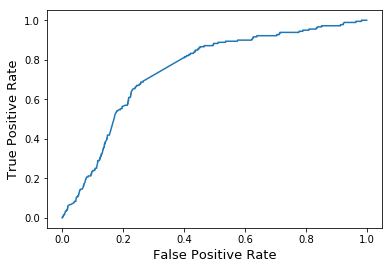

In [199]:
# build model for RandomForest
def build_model():
    '''
    This function builds the ML model using the following steps:
    1. Create pipline object using a list of (key, value) pairs
    2. Create dictinary of parameters to be optimized
    3. Create GridSearchCV object
    
    INPUT
    None
    
    OUTPUT
    cv - GridSearchCV object
    '''
    pipeline = Pipeline([
        ('scaler', Scaler(mode=None)),
        ('imputer', Imputer()),
        ('clf', RandomForestClassifier())
    ])

    parameters = {
        'imputer__strategy': ['mean','median'],
        'scaler__mode': ['min_max','standard'],
        'clf__min_weight_fraction_leaf': [0.005, 0.01, 0.02, 0.03, 0.04, 0.05],
        'clf__n_estimators': [100]
    },
    
    cv = GridSearchCV(pipeline, param_grid = parameters, cv=3, scoring='roc_auc', refit=True)
    
    return cv

# main function
def main():
    '''
    This function finds the best model using the folowing steps:
    1. Load explanatory and response variables
    2. Perform a loop for an increasing number of features
    3. Clean the explanatory variables
    3. Split the data in train and test datasets
    4. Train model and predict on test dataset
    5. Store the best estimator, parameters, number of features and AUC score
    
    INPUT
    None
    
    OUTPUT
    fpr - false positive rates for the test data for the best model (ndarray)
    tpr - true positive rates for the test data for the best model (ndarray)
    threshold - thresholds on the decision function used to compute fpr and tpr (ndarray)
    y_scores - class probabilities of the test samples for the best model (ndarray)
    best_parameters - parameter setting for the best estimator (dict)
    best_estimator - estimator which gave highest score (object)
    results - number of features for best scores (dict)
    best_auc - mean cross-validated auc-score for the best model (float)
    auc_test_select - auc-score for the best model on the test data (float)
    '''
    # load explanatory and response variables
    X, y = load_data()
    best_auc = 0
    # make loop over features
    for f in range(2,30,2):
        features = df_p_values['features'][:f]
        
        # clean explanatory variables
        cleaner_obj_X = TrainingDataCleaner(features)
        X_1 = cleaner_obj_X.fit_transform(X)
        
        # split the data in train and test datasets
        X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.33, random_state=42)
        
        # train model and predict on test data
        model = build_model()
        model.fit(X_train, y_train)
        auc = model.best_score_
        y_probas = model.predict_proba(X_test)
        y_scores = y_probas[:,1]
        auc_test = roc_auc_score(y_test, y_scores)
        
        # store best estimator, parameters, number of features and auc scores
        if auc > best_auc:
            fpr, tpr, threshold = roc_curve(y_test, y_scores)
            best_parameters = model.best_params_
            best_estimator = model.best_estimator_
            results={'num_features': len(features)}
            auc_test_select = auc_test
            best_auc = auc
            
    return fpr, tpr, threshold, y_scores, best_parameters, best_estimator, results, best_auc, auc_test_select
    
fpr, tpr, threshold, y_scores, best_parameters, best_estimator, results, best_auc, auc_test_select = main()

# plot roc curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
ax.yaxis.label.set_size(13)
ax.xaxis.label.set_size(13)
fig.savefig('roc_curve_RF.png', dpi=300)

print('Best AUC:', best_auc)
print('AUC for test set:', auc_test_select)
print('Number of features:', results['num_features'])
print('Best parameters:')
print(best_parameters)

# store best estimator and number of features
joblib.dump(best_estimator, 'best_estimator_forest.pkl', compress = 1)
joblib.dump(results['num_features'], 'num_features_forest.pkl', compress = 1)

Finally we train a **Gradient Boosting** classifier.

Best AUC: 0.77557512672
AUC for test set: 0.748891082005
Number of features: 22
Best parameters:
{'clf__min_weight_fraction_leaf': 0.04, 'clf__n_estimators': 100, 'imputer__strategy': 'mean', 'scaler__mode': 'min_max'}


['num_features_boost.pkl']

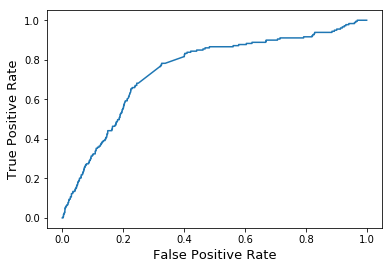

In [200]:
# build model for Gradient Boost
def build_model():
    '''
    This function builds the ML model using the following steps:
    1. Create pipline object using a list of (key, value) pairs
    2. Create dictinary of parameters to be optimized
    3. Create GridSearchCV object
    
    INPUT
    None
    
    OUTPUT
    cv - GridSearchCV object
    '''
    pipeline = Pipeline([
        ('scaler', Scaler(mode=None)),
        ('imputer', Imputer()),
        ('clf', GradientBoostingClassifier())
    ])

    parameters = {
        'imputer__strategy': ['mean','median'],
        'scaler__mode': ['min_max','standard'],
        'clf__min_weight_fraction_leaf': [0.005, 0.01, 0.02, 0.03, 0.04, 0.05],
        'clf__n_estimators': [100]
    },
    
    cv = GridSearchCV(pipeline, param_grid = parameters, cv=3, scoring='roc_auc', refit=True)
    
    return cv

# main function
def main():
    '''
    This function finds the best model using the folowing steps:
    1. Load explanatory and response variables
    2. Perform a loop for an increasing number of features
    3. Clean the explanatory variables
    3. Split the data in train and test datasets
    4. Train model and predict on test dataset
    5. Store the best estimator, parameters, number of features and AUC score
    
    INPUT
    None
    
    OUTPUT
    fpr - false positive rates for the test data for the best model (ndarray)
    tpr - true positive rates for the test data for the best model (ndarray)
    threshold - thresholds on the decision function used to compute fpr and tpr (ndarray)
    y_scores - class probabilities of the test samples for the best model (ndarray)
    best_parameters - parameter setting for the best estimator (dict)
    best_estimator - estimator which gave highest score (object)
    results - number of features for best scores (dict)
    best_auc - mean cross-validated auc-score for the best model (float)
    auc_test_select - auc-score for the best model on the test data (float)
    '''
    # load explanatory and response variables
    X, y = load_data()
    best_auc = 0
    # make loop over features
    for f in range(2,30,2):
        features = df_p_values['features'][:f]
        
        # clean explanatory variables
        cleaner_obj_X = TrainingDataCleaner(features)
        X_1 = cleaner_obj_X.fit_transform(X)
        
        # split the data in train and test datasets
        X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.33, random_state=42)
        
        # train model and predict on test data
        model = build_model()
        model.fit(X_train, y_train)
        auc = model.best_score_
        y_probas = model.predict_proba(X_test)
        y_scores = y_probas[:,1]
        auc_test = roc_auc_score(y_test, y_scores)
        
        # store best estimator, parameters, number of features and auc scores
        if auc > best_auc:
            fpr, tpr, threshold = roc_curve(y_test, y_scores)
            best_parameters = model.best_params_
            best_estimator = model.best_estimator_
            results={'num_features': len(features)}
            auc_test_select = auc_test
            best_auc = auc
            
    return fpr, tpr, threshold, y_scores, best_parameters, best_estimator, results, best_auc, auc_test_select
    
fpr, tpr, threshold, y_scores, best_parameters, best_estimator, results, best_auc, auc_test_select = main()

# plot roc curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
ax.yaxis.label.set_size(13)
ax.xaxis.label.set_size(13)
fig.savefig('roc_curve_GB.png', dpi=300)

print('Best AUC:', best_auc)
print('AUC for test set:', auc_test_select)
print('Number of features:', results['num_features'])
print('Best parameters:')
print(best_parameters)

# store best estimator and number of features
joblib.dump(best_estimator, 'best_estimator_boost.pkl', compress = 1)
joblib.dump(results['num_features'], 'num_features_boost.pkl', compress = 1)

When comparing the models, we notice that the Random Forest classifier performs substantially better than the Logistic Regresion classifier, and the Gradient Boosting classifier performs slightly better than the Random Forest classifier. The AUC score (value under the curve) for cross-validation is 0.69 for Logistic Regression, 0.77 for Random Forest, and 0.78 for Gradient Boosting. The scores for the test dataset are similar to the scores obtained from cross-validation. The ROC-AUC metric seems to work well for the imbalanced dataset used here. The number of features is reduced from 600 down to 10-22, showing that a Mann-Whitney U test can be used to reduce the dimensionality of a dataset. 

### PART 3

The best model is then used to predict a response for the '...TEST.csv' data.

In [ ]:
def load_test_data():
    '''
    This function loads the TEST data.
    
    INPUT
    None
    
    OUTPUT
    X - explanatory variables (DataFrame)
    LNR - individuals ID's (Series)
    '''
    mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)
    X, LNR = mailout_test, mailout_test['LNR']
    
    return X, LNR

In [ ]:
# DEPLOY ON TEST DATA
best_estimator = joblib.load('best_estimator_boost.pkl')
num_features = joblib.load('num_features_boost.pkl')

model = build_model()
best_pipe = best_estimator

#load data
X, LNR = load_test_data()
features = df_p_values['features'][:num_features]
cleaner_obj = TrainingDataCleaner(features)
X_trans = cleaner_obj.fit_transform(X)
    
# make predicions
y_probas = best_pipe.predict_proba(X_trans)
y_scores = y_probas[:,1]

The predictions are saved in a csv file together with the Individuals ID's

In [ ]:
# Create and save a DataFrame for submission
my_submission = pd.DataFrame({'LNR': LNR, 'RESPONSE': y_scores})
my_submission.to_csv('predict_proba.csv', index=False)